In [2]:
import sys, os
import random
import numpy as np
import csv
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
from keras import layers
from keras.callbacks import LearningRateScheduler
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def readCSV(folder, array,y):
    CSV = [os.path.join(root, filename)
          for root, dirs, files in os.walk(folder)
          for filename in files
          if filename.lower().endswith('.csv')]
    for fileIn in CSV:
        if 'fist' in fileIn:
            for x in range(50):
                y.append(0)
        else:
            for x in range(50):
                y.append(1)
        inArr=[]
        with open(fileIn, 'r') as file: 
            reader = csv.reader(file)
            next(reader)
            numSamples = 0;
            x = 0
            for lines in reader:
                lines.pop()
                if np.size(lines)!=6:
                    print(np.size(lines))
                    print(fileIn)
                    return -1
                for vals in lines:
                  inArr.append(float(vals))
                x = x + 1 
                if x >= 119:
                    numSamples=numSamples+1
                    array.append(inArr)
                    x = 0 
                    inArr = []
    x_train, x_test, y_train, y_test = train_test_split(array, y,test_size=.3)
    TEST_SPLIT = len(x_test) * .5
    # Use np.split to chop our data into three parts.
    # The second argument to np.split is an array of indices where the data will be
    # split. We provide two indices, so the data will be divided into three chunks.
    x_test, x_validate = np.split(x_test, [int(TEST_SPLIT)])
    y_test, y_validate = np.split(y_test, [int(TEST_SPLIT)])
    return [x_train, x_test, x_validate, y_train, y_test, y_validate]

In [50]:
X = []
y = []
Vals = readCSV('C:\\Users\\hazel\\Desktop\\IMU\\Jake Keels - 2022-03-01 19.32.11 - Jake_Keels',X,y)

In [4]:
def mlpModel(x_train, x_validate,y_train,y_validate):
    model = keras.models.Sequential()
    #model.add(Dense(64,activation='relu'))
    model.add(Dense(128,input_dim = 714,activation='relu'))
   
    model.add(Dense(64,activation='relu'))
    #model.add(Dropout(.2))
    model.add(Dense(2, activation='softmax'))
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',#'val_accuracy', 
                                             patience = 2, 
                                             restore_best_weights = True)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])#'mae',
    return model.fit(np.array(x_train),
                     np.array(y_train),
                     epochs=20, 
                     verbose = True, 
                     #batch_size = int(len(ic)*8/125),
                     #steps_per_epoch = 50,
                     batch_size = 32,
                     callbacks=[callback], 
                     validation_data=(x_validate, y_validate)),model

In [93]:
history, model = mlpModel(Vals[0],Vals[2],Vals[3],Vals[5])

Epoch 1/20
3/3 [==============================] - 0s 45ms/step - loss: 35.1190 - accuracy: 0.5857 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 0s 9ms/step - loss: 1.0877 - accuracy: 0.9571 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [5]:
def mlpStats(history,model,x_test,y_test):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs[1:], train_loss[1:], 'g.', label='Training loss')
    plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    y_pred = model.predict(x_test)
    y_pred_bool = np.argmax(y_pred, axis=1)
    print(metrics.classification_report(y_test, y_pred_bool))
    cm = metrics.confusion_matrix(y_test, y_pred_bool) 
    sns.heatmap(cm, annot=True,cmap='icefire')

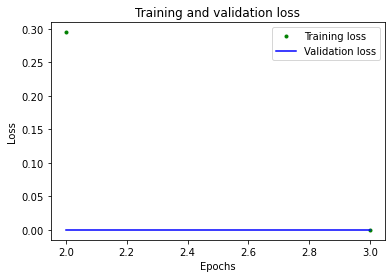

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



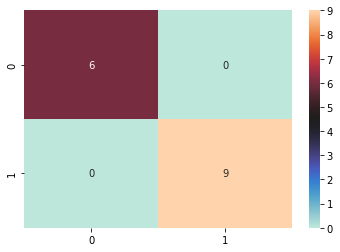

In [66]:
mlpStats(history, model, Vals[1],Vals[4])

In [6]:
def mlpModelPrune(x_train, x_validate,y_train,y_validate,model):
    end_step = 10 * 3
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,final_sparsity=0.88,
                                                               begin_step=0,end_step=end_step)}
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
    
    model_for_pruning = prune_low_magnitude(model, **pruning_params)

    model_for_pruning.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])
    model_for_pruning.fit(np.array(x_train),
                     np.array(y_train),
                     epochs=25, 
                     verbose = True, 
                     callbacks=callbacks, 
                     validation_data=(x_validate, y_validate))
    #model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    return model_for_pruning

In [108]:
prunedModel = mlpModelPrune(Vals[0],Vals[1],Vals[3],Vals[4],model)

Epoch 1/25
3/3 [==============================] - 1s 59ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/25
3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/25
3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/25
3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/25
3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.000

In [106]:
print(model.summary())
print(prunedModel.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               91520     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 2)                 130       
                                                                 
Total params: 99,906
Trainable params: 99,906
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense_2  (None, 128)              182914    
 1 (PruneLowMagnitude)                                           
                       

In [7]:
X = []
y = []
ValsWhole = readCSV('C:\\Users\\hazel\\Desktop\\IMU',X,y)

Epoch 1/20
44/44 [==============================] - 1s 4ms/step - loss: 5.2790 - accuracy: 0.8414 - val_loss: 1.6003 - val_accuracy: 0.8867
Epoch 2/20
44/44 [==============================] - 0s 1ms/step - loss: 0.7395 - accuracy: 0.9436 - val_loss: 1.0752 - val_accuracy: 0.9167
Epoch 3/20
44/44 [==============================] - 0s 1ms/step - loss: 0.2563 - accuracy: 0.9664 - val_loss: 0.7480 - val_accuracy: 0.9333
Epoch 4/20
44/44 [==============================] - 0s 1ms/step - loss: 0.1196 - accuracy: 0.9757 - val_loss: 0.5809 - val_accuracy: 0.9433
Epoch 5/20
44/44 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.9829 - val_loss: 0.5592 - val_accuracy: 0.9533
Epoch 6/20
44/44 [==============================] - 0s 1ms/step - loss: 0.0699 - accuracy: 0.9843 - val_loss: 0.6983 - val_accuracy: 0.9433
Epoch 7/20
44/44 [==============================] - 0s 1ms/step - loss: 0.0543 - accuracy: 0.9843 - val_loss: 0.6300 - val_accuracy: 0.9467


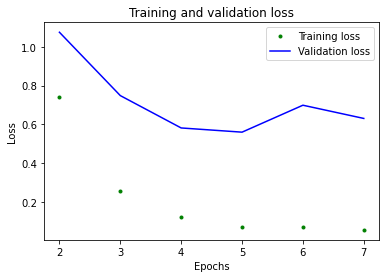

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       110
           1       0.96      0.96      0.96       190

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



C:\Users\hazel\anaconda3\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  mask = self.add_variable(
C:\Users\hazel\anaconda3\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  threshold = self.add_variable(
C:\Users\hazel\anaconda3\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.pruning_step = self.add_variable(


Epoch 1/25
44/44 [==============================] - 1s 4ms/step - loss: 0.4751 - accuracy: 0.9564 - val_loss: 1.6418 - val_accuracy: 0.9067
Epoch 2/25
44/44 [==============================] - 0s 2ms/step - loss: 0.4811 - accuracy: 0.9636 - val_loss: 0.3178 - val_accuracy: 0.9667
Epoch 3/25
44/44 [==============================] - 0s 2ms/step - loss: 0.3202 - accuracy: 0.9671 - val_loss: 0.4831 - val_accuracy: 0.9533
Epoch 4/25
44/44 [==============================] - 0s 2ms/step - loss: 0.0945 - accuracy: 0.9771 - val_loss: 0.4507 - val_accuracy: 0.9600
Epoch 5/25
44/44 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9807 - val_loss: 0.5680 - val_accuracy: 0.9567
Epoch 6/25
44/44 [==============================] - 0s 2ms/step - loss: 0.0958 - accuracy: 0.9821 - val_loss: 0.5270 - val_accuracy: 0.9567
Epoch 7/25
44/44 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.9836 - val_loss: 0.5458 - val_accuracy: 0.9600
Epoch 8/25
44/44 [==

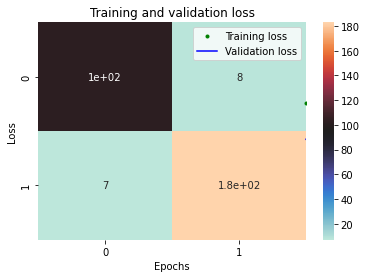

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       110
           1       0.94      0.97      0.96       190

    accuracy                           0.94       300
   macro avg       0.95      0.93      0.94       300
weighted avg       0.94      0.94      0.94       300



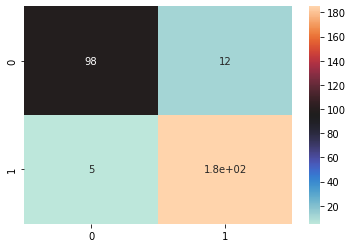

In [8]:
historyW, modelW = mlpModel(ValsWhole[0],ValsWhole[2],ValsWhole[3],ValsWhole[5])
mlpStats(historyW, modelW, ValsWhole[1],ValsWhole[4])
prunedModel = mlpModelPrune(ValsWhole[0],ValsWhole[1],ValsWhole[3],ValsWhole[4],modelW)
mlpStats(historyW, prunedModel, ValsWhole[1],ValsWhole[4])